In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.special import gamma
from scipy.io import loadmat

import math


from RW_NN import IQ_gen_NN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 3024)              12096     
                                                                 
 reshape_1 (Reshape)         (None, 63, 48)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 126, 48)          11568     
 se)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 126, 1)           241       
 nspose)                                                         
                                                                 
 reshape_2 (Reshape)         (None, 126)               0         
                                                                 
Total params: 23,905
Trainable params: 23,905
Non-trai

## Load data

In [2]:
#### Meshgrid ####
n_grid = 100
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z)

# calculate scattering function
box_size = 2
n_grid_scale = 256
scale = n_grid_scale/r_grid[0].shape[0]
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

#################################
S_q_Grid = []
p_Grid = []
for i in range(10):
    #### load data ####
    filename = '../training_set/alpha/grid/S_q_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']

    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

for i in range(10):
    #### load data ####
    filename = '../training_set/alpha/grid/S_q_{}.5.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']

    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

S_q_Grid = np.array(S_q_Grid).reshape(100*len(p_Grid),128)[:,1:-1].astype(np.float32)
p_Grid = np.array(p_Grid).reshape(100*len(p_Grid),3)
S_q_sm_Grid = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Grid)])).astype(np.float32)
log_S_q_Grid = np.log(S_q_Grid)
log_S_q_sm_Grid = np.log(S_q_sm_Grid)

k_z = p_Grid[:,0].astype(np.float32)
alpha = p_Grid[:,1].astype(np.float32)
kappa = p_Grid[:,2].astype(np.float32)
logkappa = np.log(kappa).astype(np.float32)
set_k_z = np.unique(k_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique(kappa))

print('\nk_z in')
print(set_k_z)
print('\nalpha in')
print(set_alpha)
print('\nkappa in')
print(set_kappa)

#################################
S_q_Rand = []
p_Rand = []
for i in range(10):
    #### load data ####
    filename = '../training_set/alpha/rand/S_q_rand_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']

    S_q_Rand.append(S_q_kxy)
    p_Rand.append(k_grid)

S_q_Rand = np.array(S_q_Rand).reshape(100*len(p_Rand),128)[:,1:-1]
p_Rand = np.array(p_Rand).reshape(100*len(p_Rand),3)
S_q_sm_Rand = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Rand)]))
log_S_q_Rand = np.log(S_q_Rand)
log_S_q_sm_Rand = np.log(S_q_sm_Rand)

k_z_Rand = p_Rand[:,0].astype(np.float32)
alpha_Rand = p_Rand[:,1].astype(np.float32)
kappa_Rand = p_Rand[:,2].astype(np.float32)
logkappa_Rand = np.log(kappa_Rand)


p_Rand = np.array(p_Rand)
index_kappa = kappa_Rand>=1

p_Rand = p_Rand[index_kappa,:]
S_q_Rand = S_q_Rand[index_kappa,:]
S_q_sm_Rand = S_q_sm_Rand[index_kappa,:]


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


In [3]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_k_z = np.abs(k_z-parameters[0])<tol
    id_alpha = np.abs(alpha-parameters[2])<tol
    id_kappa = np.abs(kappa-parameters[1])<tol
    return np.where(id_k_z*id_alpha*id_kappa)[0][0]

## Plot and fit

In [4]:
def fit_err(opti, fp_GT, IQ_MSE=0.01, index_x=[0,1,2]):
    fp_opt = fp_GT.copy()
    for i, index in enumerate(index_x):
        fp_opt[index] = opti.x[i]
        
    # https://stackoverflow.com/questions/43593592
    fp_opt_err = np.zeros(len(fp_GT))
    tmp_i = np.zeros(len(opti.x))
    for i, index in enumerate(index_x):
        tmp_i[i] = 1.0
        hess_inv_i = opti.hess_inv(tmp_i)[i]
        uncertainty_i = np.sqrt(abs(opti.fun) * IQ_MSE * hess_inv_i)
        tmp_i[i] = 0.0
        fp_opt_err[index] = uncertainty_i
        
    return fp_opt_err

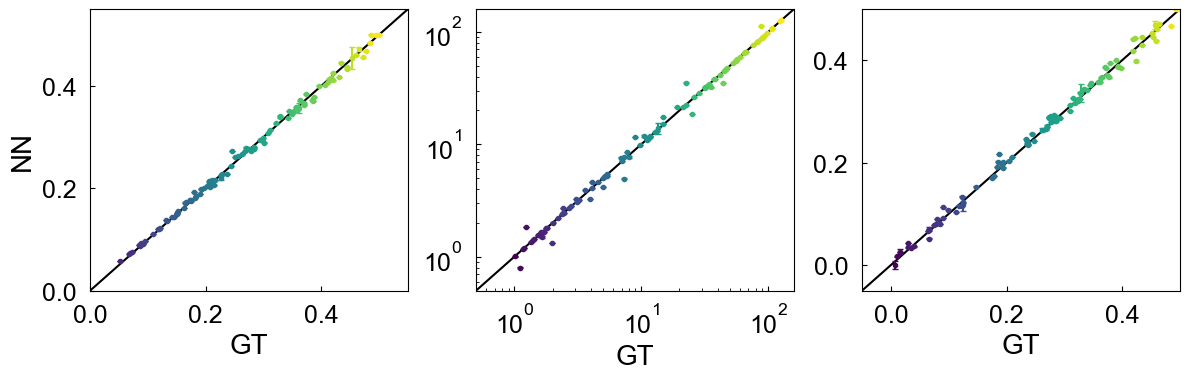

In [5]:
# random datasets
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.plot([0,0.55],[0,0.55],'-k',zorder=-1)
ax2.plot([0.5,160],[0.5,160],'-k',zorder=-1)    
ax3.plot([-0.05,0.5],[-0.05,0.5],'-k',zorder=-1)

np.random.seed(seed=114514)
index_rand = np.random.choice(np.arange(len(p_Rand)),size=100,replace=False)

fp_opt_rand = []
fp_err_rand = []
for i, index in enumerate(index_rand):
    parameters = p_Rand[index,[0,2,1]]

    ## fitting
    IQ_GT = S_q_sm_Rand[index,]
    def loss(fp):
        lmbda = np.sum((np.log(IQ_GT)-np.log(IQ_gen_NN(fp)))**2)
        return(lmbda)

    x0 = parameters
    lb =  [0, 0.125, 0]
    ub =  [10, 150, 0.5]

    x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))

    opti_P = opt.minimize(loss, x0=np.array(x0), bounds = x_bounds,
                      method='L-BFGS-B',
                      jac='3-point',
                      options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
                      )
    fp_opt = opti_P.x
    fp_err = fit_err(opti_P, parameters, IQ_MSE=0.01**2, index_x=[0,1,2])

    fp_opt_rand.append(fp_opt)
    fp_err_rand.append(fp_err)
    # print('GT  = [{}, {}, {}]'.format(*parameters))
    # print('fit = [{}, {}, {}]'.format(*fp_k_z))

    ## plot k_z
    color = plt.cm.viridis(parameters[0]/10)
    ax1.plot(parameters[0]/20,fp_opt[0]/20,'.',color=color)
    ax1.errorbar(parameters[0]/20,fp_opt[0]/20,fp_err[0]/20,color=color, capsize=2)

    ax1.set_xlabel(r'GT',fontsize=20)
    ax1.set_ylabel(r'NN',fontsize=20)
    ax1.set_xlim([0,0.55])
    ax1.set_ylim([0,0.55])
    ax1.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    ## plot kappa
    color = plt.cm.viridis(np.log(parameters[1])/np.log(128))
    ax2.plot(parameters[1],fp_opt[1],'.',color=color)
    ax2.errorbar(parameters[1],fp_opt[1],fp_err[1],color=color, capsize=2)

    ax2.set_xlabel(r'GT',fontsize=20)
    # ax2.set_ylabel(r'NN',fontsize=20)
    ax2.set_xlim([0.5,160])
    ax2.set_ylim([0.5,160])
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    ## plot alpha
    color = plt.cm.viridis(parameters[2]/0.5)
    ax3.plot(parameters[2],fp_opt[2],'.',color=color)
    ax3.errorbar(parameters[2],fp_opt[2],fp_err[2],color=color, capsize=2)

    ax3.set_xlabel(r'GT',fontsize=20)
    # ax3.set_ylabel(r'NN',fontsize=20)
    ax3.set_xlim([-0.05,0.5])
    ax3.set_ylim([-0.05,0.5])
    ax3.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)


plt.tight_layout()



In [14]:
from scipy.io import savemat
mdic = {'fp_opt_rand':fp_opt_rand, 'fp_err_rand':fp_err_rand}
savemat('fp_opt_rand.mat', mdic)

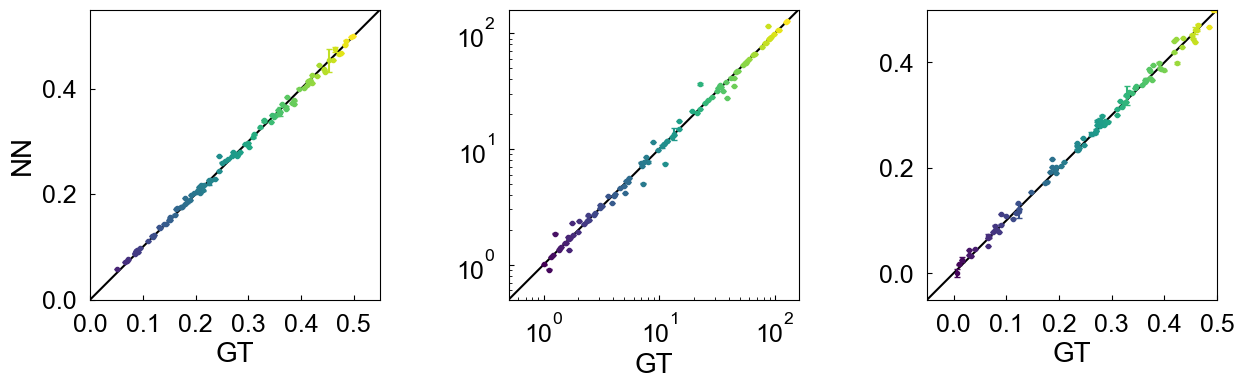

In [21]:
# plot from loaded data
data = loadmat('fp_opt_rand.mat')
fp_opt_rand = data['fp_opt_rand']

fig = plt.figure(figsize=(13.5,4.5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.plot([0,0.55],[0,0.55],'-k',zorder=-1)
ax2.plot([0.5,160],[0.5,160],'-k',zorder=-1)    
ax3.plot([-0.05,0.5],[-0.05,0.5],'-k',zorder=-1)

np.random.seed(seed=114514)
index_rand = np.random.choice(np.arange(len(p_Rand)),size=100,replace=False)

for i, index in enumerate(index_rand):
    parameters = p_Rand[index,[0,2,1]]

    ## fitting
    IQ_GT = S_q_sm_Rand[index,]
    def loss(fp):
        lmbda = np.sum((np.log(IQ_GT)-np.log(IQ_gen_NN(fp)))**2)
        return(lmbda)

    # x0 = parameters
    # lb =  [1, 0.125, 0]
    # ub =  [10, 128, 0.5]

    # x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))

    # opti_P = opt.minimize(loss, x0=np.array(x0), bounds = x_bounds,
    #                   method='L-BFGS-B',
    #                   jac='3-point',
    #                   options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
    #                   )
    # fp_opt = opti_P.x
    # fp_opt_rand.append(fp_opt)
    fp_opt = fp_opt_rand[i]
    fp_err = fp_err_rand[i]

    ## plot k_z
    color = plt.cm.viridis(parameters[0]/10)
    ax1.plot(parameters[0]/20,fp_opt[0]/20,'.',color=color)
    ax1.errorbar(parameters[0]/20,fp_opt[0]/20,fp_err[0]/20,color=color, capsize=2)

    ax1.set_xlabel(r'GT',fontsize=20)
    ax1.set_ylabel(r'NN',fontsize=20)
    ax1.set_xlim([0,0.55])
    ax1.set_ylim([0,0.55])
    ax1.set_xticks(np.arange(6)*0.1)
    ax1.set_ylim([0,0.55])
    ax1.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
    ax1.set_aspect(1)

    ## plot kappa
    color = plt.cm.viridis(np.log(parameters[1])/np.log(128))
    ax2.plot(parameters[1],fp_opt[1],'.',color=color)
    ax2.errorbar(parameters[1],fp_opt[1],fp_err[1],color=color, capsize=2)

    ax2.set_xlabel(r'GT',fontsize=20)
    # ax2.set_ylabel(r'NN',fontsize=20)
    ax2.set_xlim([0.5,160])
    ax2.set_ylim([0.5,160])
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
    ax2.set_aspect(1)

    ## plot alpha
    color = plt.cm.viridis(parameters[2]/0.5)
    ax3.plot(parameters[2],fp_opt[2],'.',color=color)
    ax3.errorbar(parameters[2],fp_opt[2],fp_err[2],color=color, capsize=2)

    ax3.set_xlabel(r'GT',fontsize=20)
    # ax3.set_ylabel(r'NN',fontsize=20)
    ax3.set_xlim([-0.05,0.5])
    ax3.set_ylim([-0.05,0.5])
    ax3.set_xticks(np.arange(6)*0.1)
    ax3.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
    ax3.set_aspect(1)


plt.tight_layout(pad=3.6)

